# リアルタイム Parabolic SAR (RPSAR) の検討

### システムパスに一つ上のディレクトリ .. を追加

In [20]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

## ここでまとめてライブラリをインポート

In [21]:
import datetime
import re

from matplotlib import (
    dates as mdates,
    font_manager as fm,
    pyplot as plt,
    ticker as ticker,
)
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.plots import getMajorXTicks
from funcs.preprocs_no_qt import (
    get_date_formatted,
    get_ohlc4analysis,
    get_tick4analysis,
)

from funcs.technical import RealTimePSAR

## ソースファイルの指定

In [22]:
#code = '7203'
code = '8306'
dateStr = '20250312'
tick_csv = '../tick/tick_%s_%s.csv' % (code, dateStr)

## 過去ログ (Tick) の読み込み

In [23]:
df = pd.read_csv(tick_csv)
# Tick データを Matplotlib で扱いやすいように整形
dateFmt = get_date_formatted(dateStr)
df = get_tick4analysis(df, dateFmt)
df

,Price
Datetime,
2025-03-12 09:00:01,1904.5
2025-03-12 09:00:04,1904.0
2025-03-12 09:00:06,1903.0
2025-03-12 09:00:09,1905.5
2025-03-12 09:00:10,1907.0
...,...
2025-03-12 15:24:53,1931.5
2025-03-12 15:24:55,1931.0
2025-03-12 15:24:57,1931.0


In [24]:
af_init=0.00005
af_step=0.00005
af_max=0.005
psar = RealTimePSAR(af_init, af_step, af_max)

for r in range(len(df)):
    t = df.index[r]
    price = df.loc[t, 'Price']
    psar.add(t, price)

df_psar = psar.get_df()
df_psar

,Price,TREND,EP,AF,PSAR
Datetime,,,,,
2025-03-12 09:00:01,1904.5,NaN,NaN,NaN,NaN
2025-03-12 09:00:04,1904.0,-1.0,1904.0,0.00005,1904.000000
2025-03-12 09:00:06,1903.0,-1.0,1903.0,0.00010,1903.999900
2025-03-12 09:00:09,1905.5,1.0,1905.5,0.00005,1903.000000
2025-03-12 09:00:10,1907.0,1.0,1907.0,0.00010,1903.000400
...,...,...,...,...,...
2025-03-12 15:24:53,1931.5,-1.0,1927.5,0.00025,1937.270319
2025-03-12 15:24:55,1931.0,-1.0,1927.5,0.00025,1937.267877
2025-03-12 15:24:57,1931.0,-1.0,1927.5,0.00025,1937.265435


## チャート

In [25]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 14

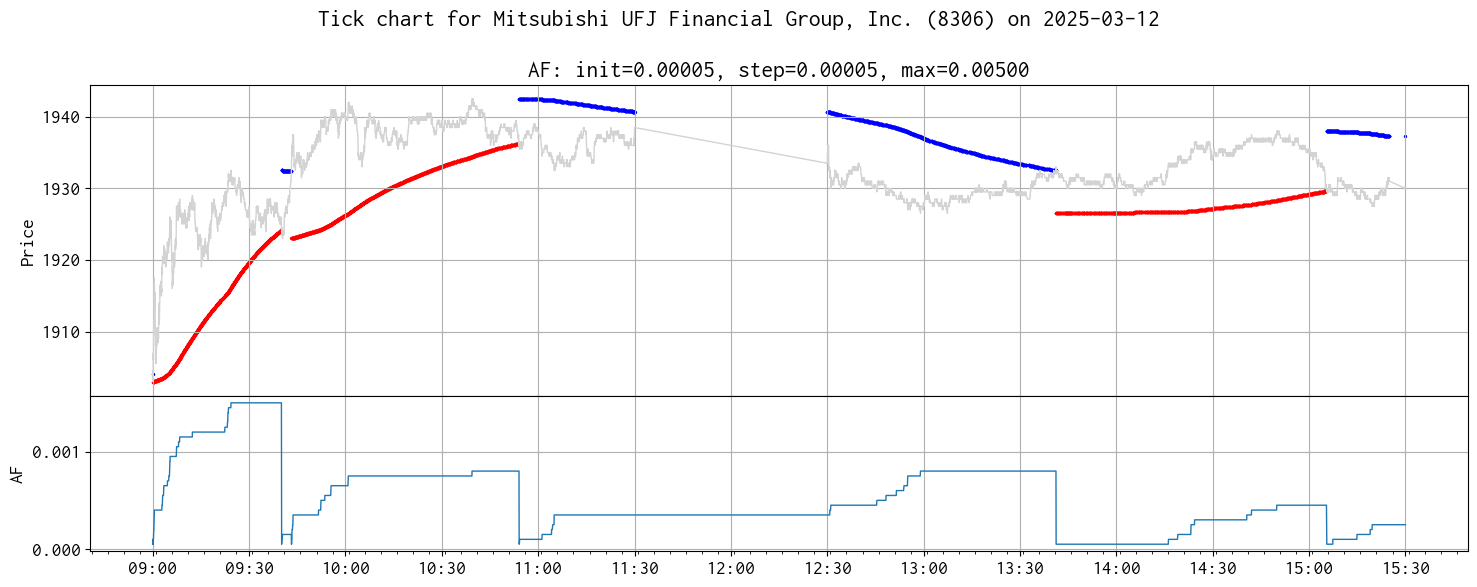

In [26]:
fig = plt.figure(figsize=(15, 6))

n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
ax = dict()
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

# Tick
ax[0].plot(df_psar['Price'], linewidth=1, color='lightgray',)

# PSAR bear - Downward trend
df_bear = df_psar[df_psar['TREND'] < 0]
ax[0].scatter(x=df_bear.index, y=df_bear['PSAR'], color='blue', s=2,)

# PSAR bull - Upward trend
df_bull = df_psar[df_psar['TREND'] > 0]
ax[0].scatter(x=df_bull.index, y=df_bull['PSAR'], color='red', s=2,)

tick_position, tick_labels = getMajorXTicks(df)
ax[0].set_xticks(ticks=tick_position, labels=tick_labels,)
ax[0].xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[0].set_ylabel('Price')

ax[0].set_title('AF: init=%.5f, step=%.5f, max=%.5f' % (af_init, af_step, af_max))

# AF
ax[1].plot(df_psar['AF'], linewidth=1, color='C0',)
ax[1].set_ylabel('AF')


ticker = yf.Ticker('%s.T' % code)
try:
    suptitle = 'Tick chart for %s (%s) on %s' % (ticker.info['longName'], code, dateFmt)
except KeyError:
    suptitle = 'Tick chart for %s on %s' % (code, dateFmt)

plt.suptitle(suptitle)

plt.tight_layout()
plt.savefig('screenshots/tick_chart_%s_%s.png' % (code, dateFmt))
plt.show()